In [ ]:
import sys

sys.path.append("../")

In [1]:
import pickle
from itertools import product
from pathlib import Path
from random import choices

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import seaborn as sns
from scipy.ndimage import uniform_filter
from eval import (
    Episode,
    Study,
    number_of_better_final_beams,
    plot_beam_parameters_on_screen,
    plot_best_mae_box,
    plot_best_mae_diff_over_problem,
    plot_best_mae_over_time,
    plot_final_mae_box,
    plot_mae_over_time,
    plot_screen_image,
    plot_steps_to_convergence_box,
    plot_steps_to_threshold_box,
    problem_aligned,
    screen_extent,
)


In [2]:
plt.style.use(["science", "nature"])
FIG_DIR = "./figures"


In [3]:
rl_real = Study.load(
    "data/bo_vs_rl/real/rl",
    runs="*problem_*",
    name="RLO (real world)",
)
bo_real = Study.load(
    "data/bo_vs_rl/real/bo",
    runs="*problem_*",
    name="BO (real world)",
)
i = 38


In [4]:
rl_episode = rl_real.get_episodes_by_problem(i)[0]
bo_episode = bo_real.get_episodes_by_problem(i)[0]

first_rl_screen_image = (
    rl_episode.infos[0]["screen_before_reset"]
    if "screen_before_reset" in rl_episode.infos[0]
    else rl_episode.infos[0]["beam_image"]
)
last_rl_screen_image = rl_episode.infos[-1]["beam_image"]
first_bo_screen_image = (
    bo_episode.infos[0]["screen_before_reset"]
    if "screen_before_reset" in bo_episode.infos[0]
    else bo_episode.infos[0]["beam_image"]
)
last_bo_screen_image = bo_episode.infos[-1]["beam_image"]
shared_vmax = np.max(
    np.stack(
        [
            uniform_filter(first_rl_screen_image, size=10),
            uniform_filter(last_rl_screen_image, size=10),
            uniform_filter(first_bo_screen_image, size=10),
            uniform_filter(last_bo_screen_image, size=10),
        ]
    )
)

target_beam_rl = rl_episode.observations[0]["target"]
target_beam_bo = bo_episode.observations[0]["target"]


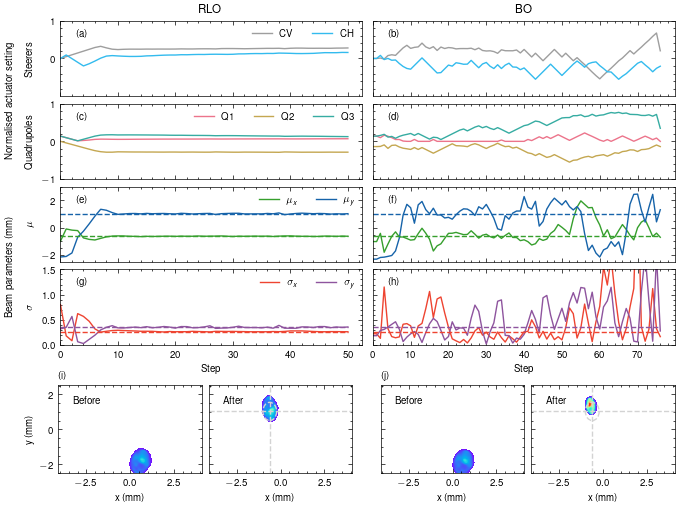

In [5]:
# Plot Layout
fig = plt.figure(figsize=(510 / 72.72 * 1.205, 510 / 72.72 * 1.205 * 0.74))
# gs = matplotlib.gridspec.GridSpec(2,1, height_ratios=[4,1])
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1.8], hspace=0.05)
gs00 = gs[0].subgridspec(4, 3, width_ratios=[0.1, 1, 1], hspace=0.1, wspace=0.05)
gs01 = gs[1].subgridspec(1, 6, width_ratios=[0.22, 1, 1, 0.1, 1, 1], wspace=0.07)

ax_rl_steerer = fig.add_subplot(gs00[0, 1])
ax_rl_quadrupole = fig.add_subplot(gs00[1, 1], sharex=ax_rl_steerer)
ax_rl_mu = fig.add_subplot(gs00[2, 1], sharex=ax_rl_steerer)
ax_rl_sigma = fig.add_subplot(gs00[3, 1], sharex=ax_rl_steerer)

ax_bo_steerer = fig.add_subplot(gs00[0, 2], sharey=ax_rl_steerer)
ax_bo_quadrupole = fig.add_subplot(gs00[1, 2], sharey=ax_rl_quadrupole)
ax_bo_mu = fig.add_subplot(gs00[2, 2], sharey=ax_rl_mu)
ax_bo_sigma = fig.add_subplot(gs00[3, 2], sharey=ax_rl_sigma)

ax_rl_before = fig.add_subplot(gs01[1])
ax_rl_after = fig.add_subplot(gs01[2])
ax_bo_before = fig.add_subplot(gs01[4])
ax_bo_after = fig.add_subplot(gs01[5])

ax_dummy1 = fig.add_subplot(gs00[:2, 0])
ax_dummy2 = fig.add_subplot(gs00[2:, 0])
# ax_dummy1.set_visible(False)
for ax in [ax_dummy1, ax_dummy2]:
    ax.set_xticks([])
    ax.set_yticks([])
    [ax.spines[side].set_visible(False) for side in ("left", "top", "right", "bottom")]
    ax.patch.set_visible(False)

for ax in [
    ax_rl_steerer,
    ax_rl_quadrupole,
    ax_rl_mu,
    ax_bo_steerer,
    ax_bo_quadrupole,
    ax_bo_mu,
]:
    ax.xaxis.set_tick_params(labelbottom=False)
for ax in [ax_bo_steerer, ax_bo_quadrupole, ax_bo_mu, ax_bo_sigma]:
    ax.yaxis.set_tick_params(labelleft=False)
# for ax in [
#     ax_bo_corr,
#     ax_bo_quad,
#     ax_bo_mu,
#     ax_bo_sigma,
#     ax_rl_after,
#     ax_bo_before,
#     ax_bo_after,
# ]:
#     ax.set_yticks([])
for ax in [ax_rl_after, ax_bo_before, ax_bo_after]:
    ax.set_yticklabels([])

#############
# Plotting
rl_episode.plot_quadrupoles(
    ax=ax_rl_quadrupole, xlabel=False, ylabel=False, legend=False, normalize=True
)
ax_rl_quadrupole.legend(loc="upper right", ncol=3)
rl_episode.plot_correctors(
    ax=ax_rl_steerer, xlabel=False, ylabel=False, legend=False, normalize=True
)
ax_rl_steerer.legend(loc="upper right", ncol=2)

rl_episode.plot_beam_parameters(
    ax=ax_rl_mu, xlabel=False, mode="mu", legend=False, ylabel=False
)
ax_rl_mu.legend(loc="upper right", ncol=2)
rl_episode.plot_beam_parameters(
    ax=ax_rl_sigma, xlabel=False, mode="sigma", legend=False, ylabel=False
)
ax_rl_sigma.legend(loc="upper right", ncol=2)

bo_episode.plot_quadrupoles(
    ax=ax_bo_quadrupole, xlabel=False, ylabel=False, legend=False, normalize=True
)
bo_episode.plot_correctors(
    ax=ax_bo_steerer, xlabel=False, ylabel=False, legend=False, normalize=True
)

bo_episode.plot_beam_parameters(
    ax=ax_bo_mu, xlabel=False, mode="mu", legend=False, ylabel=False
)
bo_episode.plot_beam_parameters(
    ax=ax_bo_sigma, xlabel=False, mode="sigma", legend=False, ylabel=False
)

#############
# Screen Images
plot_screen_image(
    image=first_rl_screen_image,
    resolution=rl_episode.infos[0]["screen_resolution"],
    pixel_size=rl_episode.infos[0]["pixel_size"],
    ax=ax_rl_before,
    vmax=shared_vmax,
    xlabel=False,
    ylabel=False,
)
plot_screen_image(
    image=last_rl_screen_image,
    resolution=rl_episode.infos[-1]["screen_resolution"],
    pixel_size=rl_episode.infos[-1]["pixel_size"],
    ax=ax_rl_after,
    vmax=shared_vmax,
    xlabel=False,
    ylabel=False,
)
plot_beam_parameters_on_screen(
    mu_x=target_beam_rl[0],
    sigma_x=target_beam_rl[1],
    mu_y=target_beam_rl[2],
    sigma_y=target_beam_rl[3],
    resolution=rl_episode.infos[0]["screen_resolution"],
    pixel_size=rl_episode.infos[0]["pixel_size"],
    ax=ax_rl_after,
    xlabel=False,
    ylabel=False,
)

plot_screen_image(
    image=first_bo_screen_image,
    resolution=bo_episode.infos[0]["screen_resolution"],
    pixel_size=bo_episode.infos[0]["pixel_size"],
    ax=ax_bo_before,
    vmax=shared_vmax,
    xlabel=False,
    ylabel=False,
)

plot_screen_image(
    image=last_bo_screen_image,
    resolution=bo_episode.infos[-1]["screen_resolution"],
    pixel_size=bo_episode.infos[-1]["pixel_size"],
    ax=ax_bo_after,
    vmax=shared_vmax,
    xlabel=False,
    ylabel=False,
)
plot_beam_parameters_on_screen(
    mu_x=target_beam_bo[0],
    sigma_x=target_beam_bo[1],
    mu_y=target_beam_bo[2],
    sigma_y=target_beam_bo[3],
    resolution=rl_episode.infos[0]["screen_resolution"],
    pixel_size=rl_episode.infos[0]["pixel_size"],
    ax=ax_bo_after,
    ylabel=False,
)

#############
# Labels
ax_rl_sigma.set_xlabel("Step")
ax_bo_sigma.set_xlabel("Step")
ax_dummy1.set_ylabel("Normalised actuator setting")
ax_dummy2.set_ylabel("Beam parameters (mm)")
ax_rl_sigma.set_ylabel(r"$\sigma$")
ax_rl_mu.set_ylabel(r"$\mu$")
ax_rl_steerer.set_ylabel("Steerers")
ax_rl_quadrupole.set_ylabel("Quadrupoles")

ax_rl_steerer.set_title("RLO")
ax_bo_steerer.set_title("BO")

data_axes = [
    ax_rl_steerer,
    ax_bo_steerer,
    ax_rl_quadrupole,
    ax_bo_quadrupole,
    ax_rl_mu,
    ax_bo_mu,
    ax_rl_sigma,
    ax_bo_sigma,
]
bo_axes = [ax_bo_steerer, ax_bo_quadrupole, ax_bo_mu, ax_bo_sigma]
rl_axes = [ax_rl_steerer, ax_rl_quadrupole, ax_rl_mu, ax_rl_sigma]
subfig_names = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)"]
for idx, ax in enumerate(data_axes):
    ax.text(x=0.05, y=0.8, s=subfig_names[idx], transform=ax.transAxes)

for ax in [ax_rl_mu, ax_bo_mu]:
    ax.set_ylim(-2.5, 3)
for ax in [ax_rl_sigma, ax_bo_sigma]:
    ax.set_ylim(0, 1.5)

ax_rl_before.set_ylabel("y (mm)")
for ax in [ax_rl_before, ax_rl_after, ax_bo_before, ax_bo_after]:
    ax.set_xlabel("x (mm)")
for ax in bo_axes:
    ax.set_xlim([0, None])
for ax in rl_axes:
    ax.set_xlim([0, None])

ax_rl_before.text(0.1, 0.8, "Before", transform=ax_rl_before.transAxes)
ax_bo_before.text(0.1, 0.8, "Before", transform=ax_bo_before.transAxes)
ax_rl_after.text(0.1, 0.8, "After", transform=ax_rl_after.transAxes)
ax_bo_after.text(0.1, 0.8, "After", transform=ax_bo_after.transAxes)
ax_rl_before.text(0, 1.08, "(i)", transform=ax_rl_before.transAxes)
ax_bo_before.text(0, 1.08, "(j)", transform=ax_bo_before.transAxes)

# Fine tuning
ax_rl_steerer.set_yticks([0, 1])
fig.align_ylabels(
    [ax_rl_steerer, ax_rl_quadrupole, ax_rl_mu, ax_rl_sigma, ax_rl_before]
)

# lines_labels = [
#     ax.get_legend_handles_labels()
#     for ax in [ax_rl_steerer, ax_rl_quadrupole, ax_rl_mu, ax_rl_sigma]
# ]
# handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# # handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(
#     handles,
#     labels,
#     ncol=len(handles),
#     frameon=True,
#     edgecolor="inherit",
#     loc="lower center",
#     bbox_to_anchor=(0.5, 0.05),
# )
# fig.tight_layout()
fig.savefig(f"{FIG_DIR}/example_episodes_combined_new.pdf")
